In [8]:
from package.HmmTSModel import HmmTimeSeriesModel
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import norm
from scipy.stats import poisson
import warnings
warnings.filterwarnings("ignore")

In [127]:
%load_ext autoreload
%autoreload
from package.HmmTSModel import HmmTimeSeriesModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
import yfinance as yf
from typing import List
from pandas_datareader import data as pdr

yf.pdr_override()


def get_financial_time_series(symbol: str, start_date: str, end_date: str,
                              type: List[str] = ('Date','Open', 'High', 'Low', 
                                                 'Close', 'Adj Close', 'Volume','LIBOR')):
    return pdr.get_data_yahoo(symbol, start=start_date, end=end_date)[type]

In [129]:
company='GME'
start, end = "2019-01-01", "2021-03-25"
features = ['Open', 'High', 'Low', 'Close']
GEM_data = get_financial_time_series(company, start, end, features).reset_index()
GEM_data['frac_change'] = (np.array(GEM_data['Close']) - np.array(GEM_data['Open'])) / np.array(GEM_data['Open'])
GEM_data['frac_high'] = (np.array(GEM_data['High']) - np.array(GEM_data['Open'])) / np.array(GEM_data['Open'])
GEM_data['frac_low'] = (np.array(GEM_data['Open']) - np.array(GEM_data['Low'])) / np.array(GEM_data['Open'])
GEM_data.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,frac_change,frac_high,frac_low
0,2019-01-02,12.45,13.18,12.42,13.07,0.049799,0.058635,0.002410
1,2019-01-03,12.98,13.26,12.69,12.97,-0.000770,0.021572,0.022342
2,2019-01-04,14.03,15.29,13.70,15.24,0.086244,0.089808,0.023521
3,2019-01-07,15.11,15.81,14.94,15.48,0.024487,0.046327,0.011251
4,2019-01-08,15.50,15.89,15.15,15.81,0.020000,0.025161,0.022581


In [130]:
def stock_return(close_price:np.ndarray):
    Pt_prev = np.array(close_price)[:-1]
    Pt = np.array(close_price)[1:]
    rt = 100*(np.log(Pt) - np.log(Pt_prev))
    rt = np.insert(rt, 0, np.nan, axis=0)
    return rt

In [131]:
GEM_data['return']  = stock_return(GEM_data.Close)
GEM_data = GEM_data.dropna().reset_index(drop=True)
GEM_data.head()

,Date,Open,High,Low,Close,frac_change,frac_high,frac_low,return
0,2019-01-03,12.98,13.260000,12.69,12.97,-0.000770,0.021572,0.022342,-0.768049
1,2019-01-04,14.03,15.290000,13.70,15.24,0.086244,0.089808,0.023521,16.128452
2,2019-01-07,15.11,15.810000,14.94,15.48,0.024487,0.046327,0.011251,1.562530
3,2019-01-08,15.50,15.890000,15.15,15.81,0.020000,0.025161,0.022581,2.109384
4,2019-01-09,15.84,16.389999,15.72,15.98,0.008838,0.034722,0.007576,1.069523


In [152]:
# states_rule={
#     0: [0,10],
#     1: [-10,0],
#     2: [10, 100],
#     3: [-100, -10],
# }

states_rule={
    0: [0,100],
    1: [-100,0],
}

def states_mapping(x):
    for state, rng in states_rule.items():
        if rng[0] < x <= rng[1]:
            return state
        
GEM_data['state'] = GEM_data['return'].map(states_mapping)

fig = px.scatter(GEM_data, x="Date", y="return", color="state", hover_data=GEM_data.columns.to_list())
fig.show()

fig = px.line(GEM_data, x="Date", y="state",  hover_data=GEM_data.columns.to_list())
fig.show()

In [153]:
HMM_features = ['state']
HMM_stock_predictor = HmmTimeSeriesModel(n_hidden_states=30,n_iter=1000,covariance_type='full')

GEM_featuring_data = GEM_data[HMM_features]

means, covars, transmat = HMM_stock_predictor.fit(GEM_featuring_data, split_data=True)

Fitting a model with 959 free scalar parameters with only 448 data points will result in a degenerate solution.


In [154]:
prediction = HMM_stock_predictor.project()

100%|██████████| 112/112 [00:06<00:00, 18.04it/s]


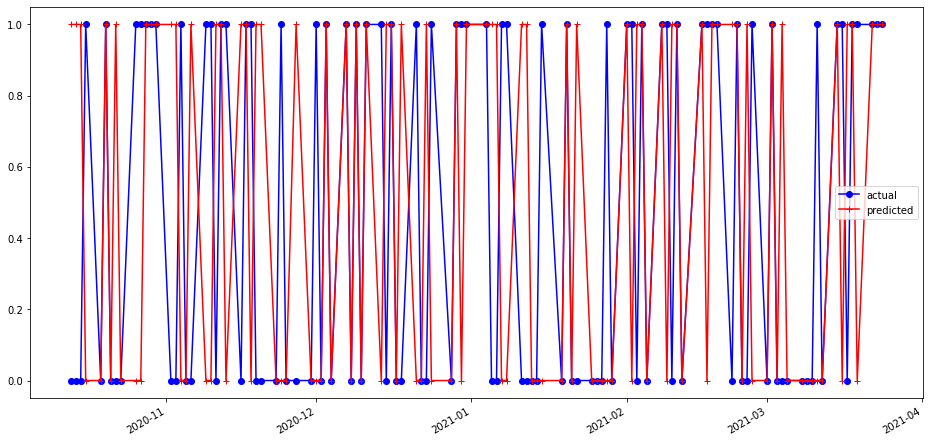

In [156]:
fig = plt.figure(figsize=(16,8))

days = np.array(GEM_data.loc[HMM_stock_predictor.projection_data.index,'Date'], dtype="datetime64[ms]")
axes = fig.add_subplot(111)
axes.plot(days, HMM_stock_predictor.projection_data, 'bo-', label="actual")
axes.plot(days, prediction, 'r+-', label="predicted")

# decoded_state = list(-(HMM_stock_predictor.hmm.predict(total_data)/3 - 1))
# axes.plot(days, decoded_state, 'gx-', label="viterbi")



fig.autofmt_xdate()

plt.legend()
plt.show()

0.5446428571428571

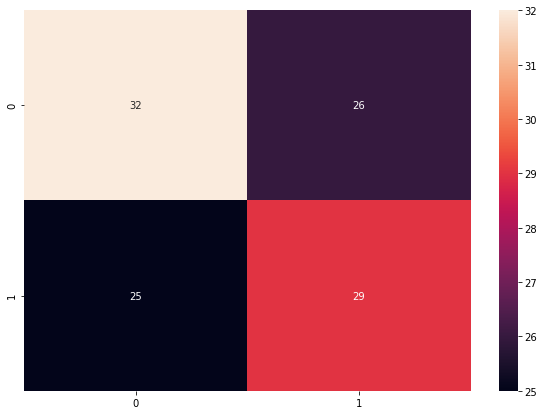

In [162]:
from sklearn.metrics import confusion_matrix
actual_state = np.array(HMM_stock_predictor.projection_data)
cm=confusion_matrix(actual_state,prediction)
df_cm = pd.DataFrame(cm, index = [i for i in np.unique(actual_state)],
                     columns = [i for i in np.unique(actual_state)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

from sklearn.metrics import accuracy_score
accuracy_score(np.array(HMM_stock_predictor.projection_data), prediction)

In [164]:
HMM_features = ['frac_change','frac_high','frac_low']
HMM_stock_predictor = HmmTimeSeriesModel(n_hidden_states=4,n_iter=1000,covariance_type='full')

GEM_featuring_data = GEM_data[HMM_features]

means, covars, transmat = HMM_stock_predictor.fit(GEM_featuring_data, split_data=True)

In [171]:
prediction = HMM_stock_predictor.project()

100%|██████████| 112/112 [01:13<00:00,  1.51it/s]


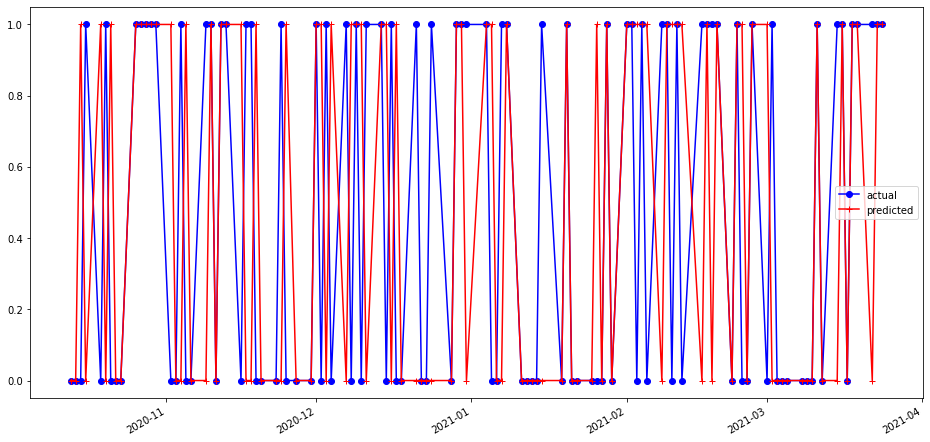

In [208]:
open_price = np.array(GEM_data.loc[HMM_stock_predictor.projection_data.index,'Open'])

predicted_frac_change, _, _ = np.array(list(zip(*prediction)))
close_prediction = open_price * (1 + predicted_frac_change)
pred_return = stock_return(close_prediction)
pred_state = list(map(states_mapping,pred_return))
pred_state = [0 if v is None else v for v in pred_state]

actual_frac_change = np.array(HMM_stock_predictor.projection_data.frac_change)
close_actual = open_price * (1 + actual_frac_change)
actual_return = stock_return(close_actual)
actual_state = list(map(states_mapping,actual_return))
actual_state = [0 if v is None else v for v in actual_state]


fig = plt.figure(figsize=(16,8))
days = np.array(GEM_data.loc[HMM_stock_predictor.projection_data.index,'Date'], dtype="datetime64[ms]")
axes = fig.add_subplot(111)
axes.plot(days, actual_state, 'bo-', label="actual")
axes.plot(days, pred_state, 'r+-', label="predicted")
fig.autofmt_xdate()

plt.legend()
plt.show()

0.6071428571428571

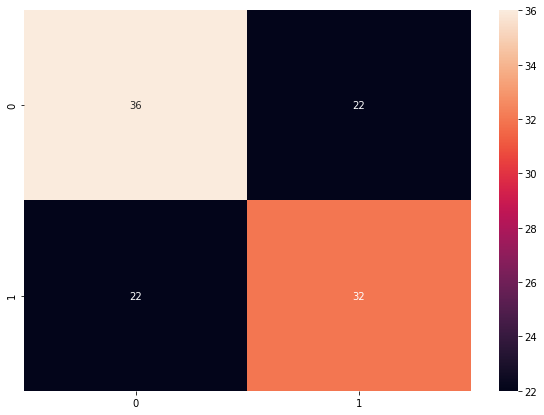

In [210]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(actual_state,pred_state)
df_cm = pd.DataFrame(cm, index = [i for i in np.unique(actual_state)],
                     columns = [i for i in np.unique(actual_state)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

from sklearn.metrics import accuracy_score
accuracy_score(actual_state, pred_state)